In [1]:
import numpy as np
import healpy as hp
from astropy.io import fits
import matplotlib.pyplot as plt
from reproject import reproject_from_healpix
from reproject import reproject_to_healpix
from astropy.wcs import WCS
from astropy_healpix import HEALPix
from astropy.coordinates import SkyCoord, ICRS, Galactic
from astropy import units as units

# 1. Calculate the FWHM of the Gaussian kernel you will use for the convolution

In [2]:
current_beam = 0.85  # This is the angular resolution of the map BEFORE the convolution in DEGREES
beam_want = 3.07 # This is the angular resolution that you want to have AFTER the convolution in DEGREES

fwhm = np.sqrt(beam_want**2 - current_beam**2)

print("The FWHM of the Gaussian kernel is", fwhm, "degrees")


The FWHM of the Gaussian kernel is 2.9499830507987665 degrees


# 2 Do this if the map is already in healpix

### 2.1. Import the map

In [3]:
data, h = hp.read_map("../Data/HASLAM-408/haslam408_dsds_Remazeilles2014.fits", h=True)

### 2.2. Change any nans in the data to zeros 

(It might be a bit sketchy to do this because that will smear the zeros around so that values around those data points are lower than they should be. But if you leave them as nans, the whole map comes out as nans)

In [4]:
inds = np.isnan(data)
data[inds] = 0

### 2.3. Do the convolution

In [5]:
smoothed_map = hp.sphtfunc.smoothing(data, fwhm=np.radians(fwhm))

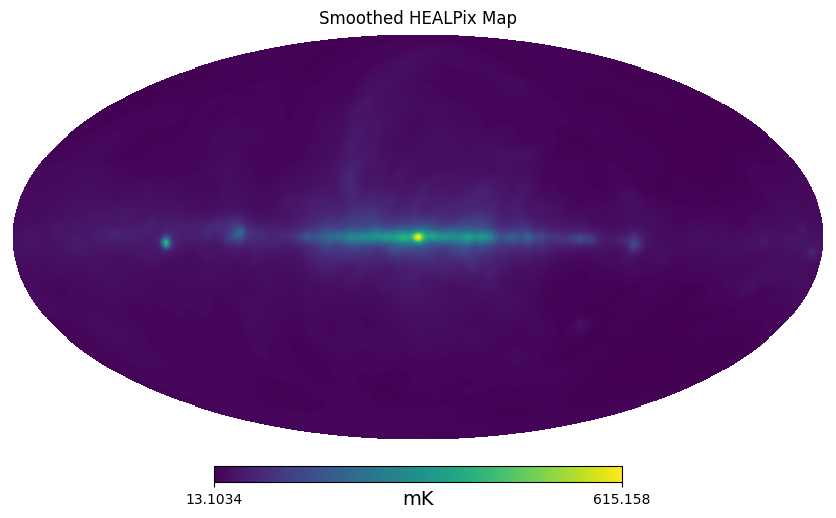

In [6]:
hp.mollview(smoothed_map, title='Smoothed HEALPix Map', unit='mK')


### 2.4. Change the bad points back to nans

In [7]:
smoothed_map[inds] = np.nan

# 3. Do this if the map starts out as a fits file (convert to healpix first)

### 3.1. Import the fits file and header

In [8]:
hdu = fits.open("../Data/HASLAM-408/haslam408_car.fits")
hdr = hdu[0].header
data = hdu[0].data

### 3.2. Convert to healpix

In [9]:
nside = 128 # this can be reduced to make bigger or smaller resolution

data_hpx, footprint = reproject_to_healpix((data, hdr), 'G', nside=nside)


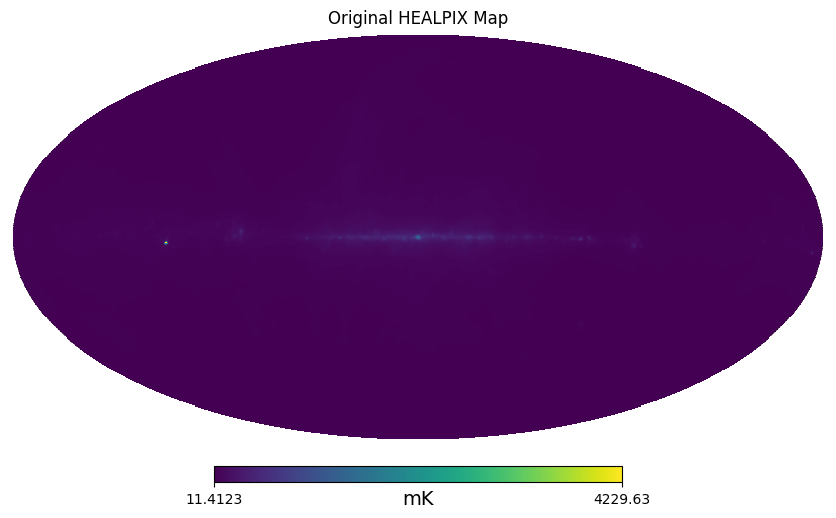

In [10]:
hp.mollview(data_hpx, title='Original HEALPIX Map', unit='mK')


### 3.3. Change any nans in the data to zeros 

(It might be a bit sketchy to do this because that will smear the zeros around so that values around those data points are lower than they should be. But if you leave them as nans, the whole map comes out as nans)

In [11]:
inds = np.isnan(data_hpx)
data_hpx[inds] = 0

### 3.4. Do the convolution

In [12]:
smoothed_map = hp.sphtfunc.smoothing(data_hpx, fwhm=np.radians(fwhm))

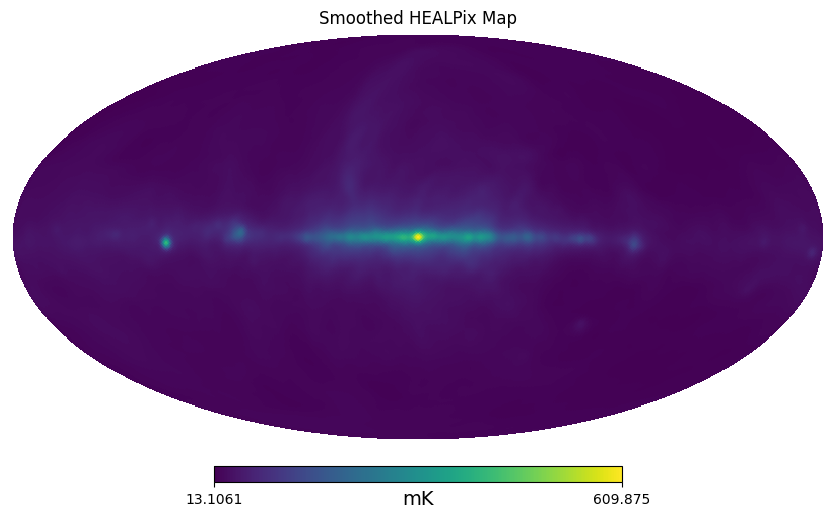

In [13]:
hp.mollview(smoothed_map, title='Smoothed HEALPix Map', unit='mK')


### 3.5. Change the bad points back to nans

In [99]:
smoothed_map[inds] = np.nan

# 4. Save the smoothed map as as a fits file

### 4.1 This function makes the header for the fits file. 
* You will need the coordinate system: 'C' for icrs equitorial, 'G' for galactic
* The projection can be '-MOL' for mollview, '-CAR' for cartesian, or '-TAN' for tangent
* pixsize is an integer specifying the pixel size in degrees
* xc and yc are the x and y coordinates to center the map on
* lonra is a list or tuple with the boundaries of the x-axis (ie -180 degrees to 180 degrees is [-180, 180])


In [14]:
def make_new_header(coordsys,proj,pixsize,xc,yc,lonra):
    if coordsys == 'C':
        ctype1 = 'RA--'+proj
        ctype2 = 'DEC-'+proj
        cs = 'icrs'
    if coordsys == 'G':
        ctype1 = 'GLON'+proj
        ctype2 = 'GLAT'+proj
        cs = 'galactic'

    if (proj == '-MOL') or (proj == '-AIT'):
        nx = int(round((((lonra[1]-lonra[0])/360)*4*np.sqrt(2)*180/(pixsize*np.pi)),0))
        ny = int(round((2*np.sqrt(2)*180/(pixsize*np.pi)),0))
    if (proj == '-CAR'):
        nx = int(round(((lonra[1]-lonra[0])/360)*(360/pixsize),0))
        ny = int(round((180/pixsize),0))
    if (proj == '-TAN'):
        nx = int(round((15*180/(pixsize*np.pi)),0))
        ny = int(round((15*180/(pixsize*np.pi)),0))

    hdr_new = fits.Header.fromstring("""
NAXIS   =                    2
CUNIT1  = 'deg     '
CUNIT2  = 'deg     '
COORDSYS= 'icrs    '
""", sep='\n')
    hdr_new['NAXIS1']  = nx 
    hdr_new['NAXIS2']  = ny
    hdr_new['CTYPE1']  = ctype1
    hdr_new['CRPIX1']  = nx/2.+0.5 
    hdr_new['CRVAL1']  = xc          
    hdr_new['CDELT1']  = -pixsize 
    hdr_new['CTYPE2']  = ctype2
    hdr_new['CRPIX2']  = ny/2.+0.5
    hdr_new['CRVAL2']  = yc
    hdr_new['CDELT2']  = pixsize
    #print(repr(hdr_new))    
    return(hdr_new,cs,ny,nx)    

### 4.2 Now make the new header and reproject the healpix map into a 2D numpy array

In [15]:
hdr_new,cs,ny,nx = make_new_header(coordsys = 'G', proj = '-CAR', pixsize=1, xc=0, yc=0, lonra=[-180,180])

array, footprint = reproject_from_healpix((smoothed_map,cs),hdr_new, nested=False)

### 4.3 Save the array as a fits file

In [34]:
filename = "smoothed_Haslam.fits"

fits.writeto(filename, array.astype('float32'), hdr_new, overwrite=True)